In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..')

In [26]:

import glob
import math

import seaborn
import pandas
from matplotlib import pyplot as plt

from src.experiments.analyze import enrich_results, plot_size_improvement, name_strategies


In [27]:
def read_parquet(pattern, **kwargs):
    frames = []
    for file in glob.glob(pattern):
        part = pandas.read_parquet(file, **kwargs)
        frames.append(part)

    df = pandas.concat(frames)
    return df
    

In [176]:
ref = read_parquet('../output/results/experiments.parquet/*sklearn*')
ref['min_samples_leaf'] = 1
ref['trees'] = 100
hyper = read_parquet('../output/results/experiments.parquet/*rf10*')
hyper['trees'] = hyper.n_estimators
data = pandas.concat([ref, hyper], ignore_index=True)
data = enrich_results(data)
data['total_size_kb'] = data.total_size / 1000
data = data
data.head(5)

,leaves_per_class,leaf_bits,split,test_nodes,test_leaves,test_leafsize,test_uniqueleaves,test_roc_auc,dataset,experiment,...,min_samples_leaf,trees,train_roc_auc,n_estimators,folds,repetitions,leaf_size,decision_size,total_size,total_size_kb
id,,,,,,,,,,,,,,,,,,,,,
173c0499-2224-4261-ae80-9e21527638ed,NaN,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,1,100,NaN,NaN,NaN,NaN,16.0,19968,19984.0,19.984
7ce39035-f8c0-436e-b687-f5d661b95ef6,1.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,1,100,NaN,NaN,NaN,NaN,16.0,19968,19984.0,19.984
8e19bdd2-87fb-4610-a9ea-313a7580fc0a,2.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,1,100,NaN,NaN,NaN,NaN,16.0,19968,19984.0,19.984
6b39543a-83e1-4c9e-8138-73f4c0bfa923,4.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,1,100,NaN,NaN,NaN,NaN,16.0,19968,19984.0,19.984
3a603762-3efe-4086-bcb9-1867af568edb,8.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,1,100,NaN,NaN,NaN,NaN,16.0,19968,19984.0,19.984


In [310]:

def compute_perf_change(df, groupby=['dataset', 'split'], metric='test_roc_auc'):
    df = df.copy()

    # Extract change in performance
    def subtract_ref(df, metric='test_roc_auc'):
        matches = df[df.experiment == 'sklearn_defaults'] # FIXME/XXX: hardcoded
        assert len(matches) == 1, matches
        ref = matches.iloc[0][metric]
        out = df[metric] - ref
        return out

    def divide_ref(df, metric='test_roc_auc'):
        matches = df[df.experiment == 'sklearn_defaults'] # FIXME/XXX: hardcoded
        assert len(matches) == 1, matches
        ref = matches.iloc[0][metric]
        out = df[metric] / ref
        return out
    
    grouped = df.groupby(groupby, as_index=False)
    df['perf_change'] = grouped.apply(subtract_ref, include_groups=False).reset_index().set_index('id')[metric]
    df['size_change'] = grouped.apply(divide_ref, metric='total_size', include_groups=False).reset_index().set_index('id')['total_size']
    
    return df

from src.experiments.analyze import name_strategies

unoptimized = name_strategies(data)
unoptimized = unoptimized[unoptimized.strategy.isin(['majority', 'original', 'joint'])]
unoptimized.loc[(unoptimized.experiment == 'sklearn_defaults') & (unoptimized.strategy != 'original')] = None
unoptimized.loc[(unoptimized.strategy == 'joint') & (unoptimized.leaf_bits != 8) & (unoptimized.leaves_per_class != 8), 'strategy'] = None
unoptimized = unoptimized.dropna(subset=['strategy'])
#print(unoptimized[unoptimized.experiment == 'sklearn_defaults']['strategy'].value_counts())
#print(unoptimized.strategy.value_counts())
unoptimized = compute_perf_change(unoptimized)
unoptimized.head(1)

#unoptimized.experiment.value_counts()

,leaves_per_class,leaf_bits,split,test_nodes,test_leaves,test_leafsize,test_uniqueleaves,test_roc_auc,dataset,experiment,...,n_estimators,folds,repetitions,leaf_size,decision_size,total_size,total_size_kb,strategy,perf_change,size_change
id,,,,,,,,,,,,,,,,,,,,,
173c0499-2224-4261-ae80-9e21527638ed,NaN,NaN,0.0,5092.0,2596.0,2.0,2.0,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,16.0,19968.0,19984.0,19.984,original,0.0,1.0


In [311]:
reduced = unoptimized.copy()
reduced = reduced[reduced.trees.isin([10])]
reduced.shape

(15444, 24)

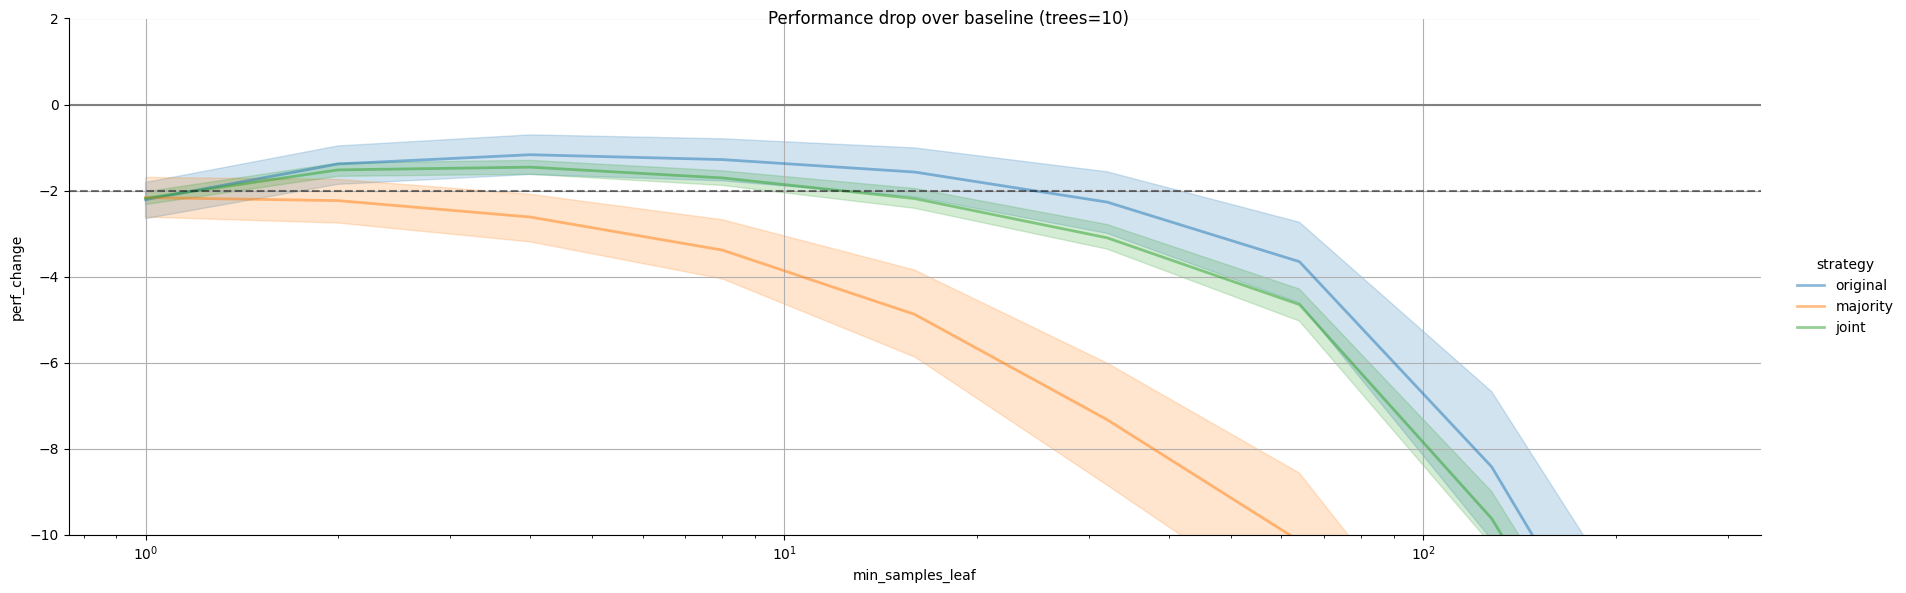

In [321]:

g = seaborn.relplot(data=reduced.reset_index(),
                    kind='line',
                    x='min_samples_leaf',
                    y='perf_change',
                    hue='strategy',
                    aspect=3, height=6,
                    legend=True,
                    #errorbar=None,
                    #err_style='bars',
                    lw=2.0,
                    alpha=0.5,
                   )
#g.set(xlim=(0, 100))
g.set(xscale="log")
#g.set(legend=False)
g.set(ylim=(-10, 2))
g.refline(y=0.0, alpha=1.0, ls='-')
g.refline(y=-2.0, alpha=0.5, color='black')
#g.refline(y=-4.0, alpha=0.5, color='orange')
for ax in g.axes.flatten():
    ax.grid() 

g.figure.suptitle('Performance drop over baseline (trees=10)')
g.figure.savefig('hyperparam-perfdrop-10trees-strategies.png')


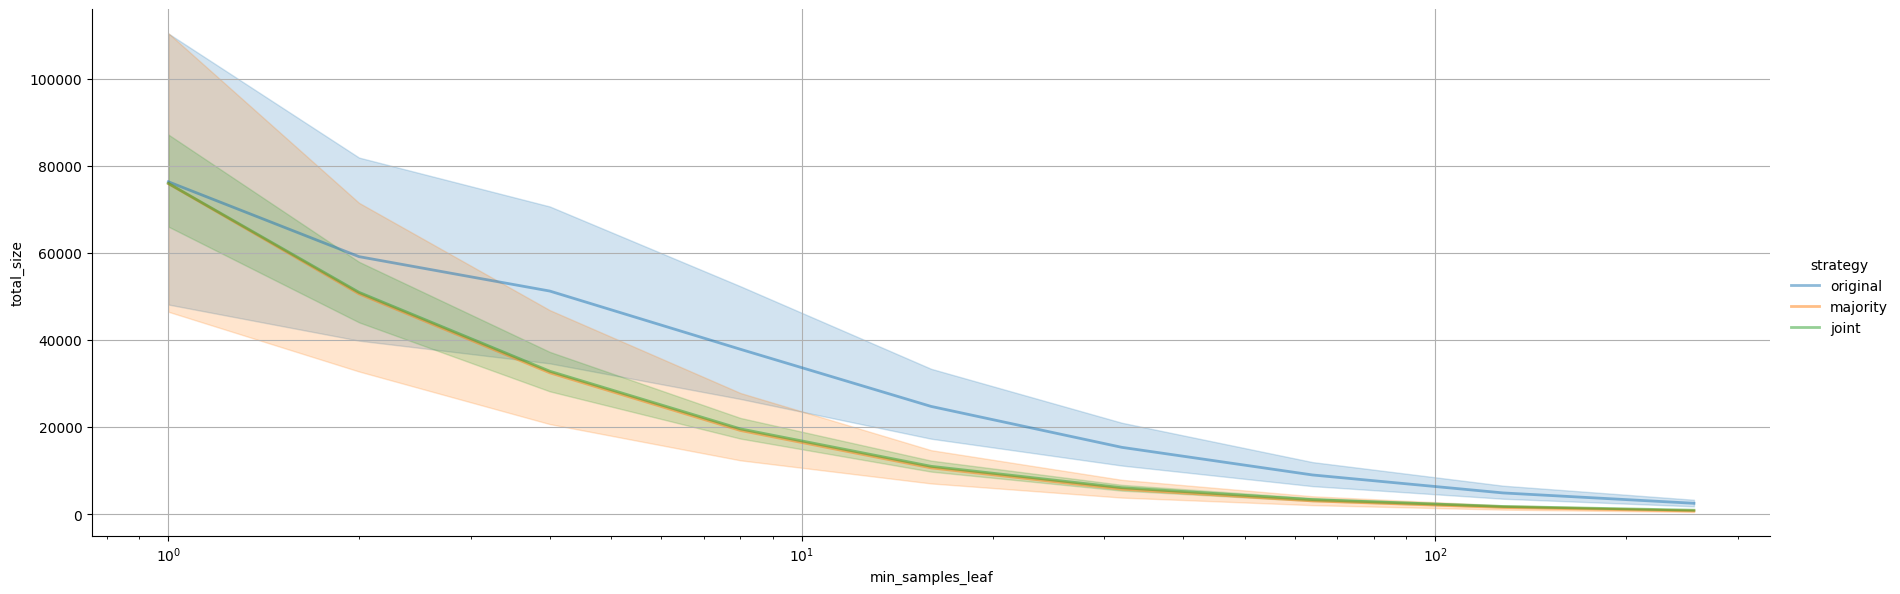

In [314]:
g = seaborn.relplot(data=reduced.reset_index(),
                    kind='line',
                    x='min_samples_leaf',
                    y='total_size',
                    hue='strategy',
                    aspect=3, height=6,
                    legend=True,
                    #errorbar=None,
                    #err_style='bars',
                    lw=2.0,
                    alpha=0.5,
                   )
g.set(xscale="log")
for ax in g.axes.flatten():
    ax.grid()


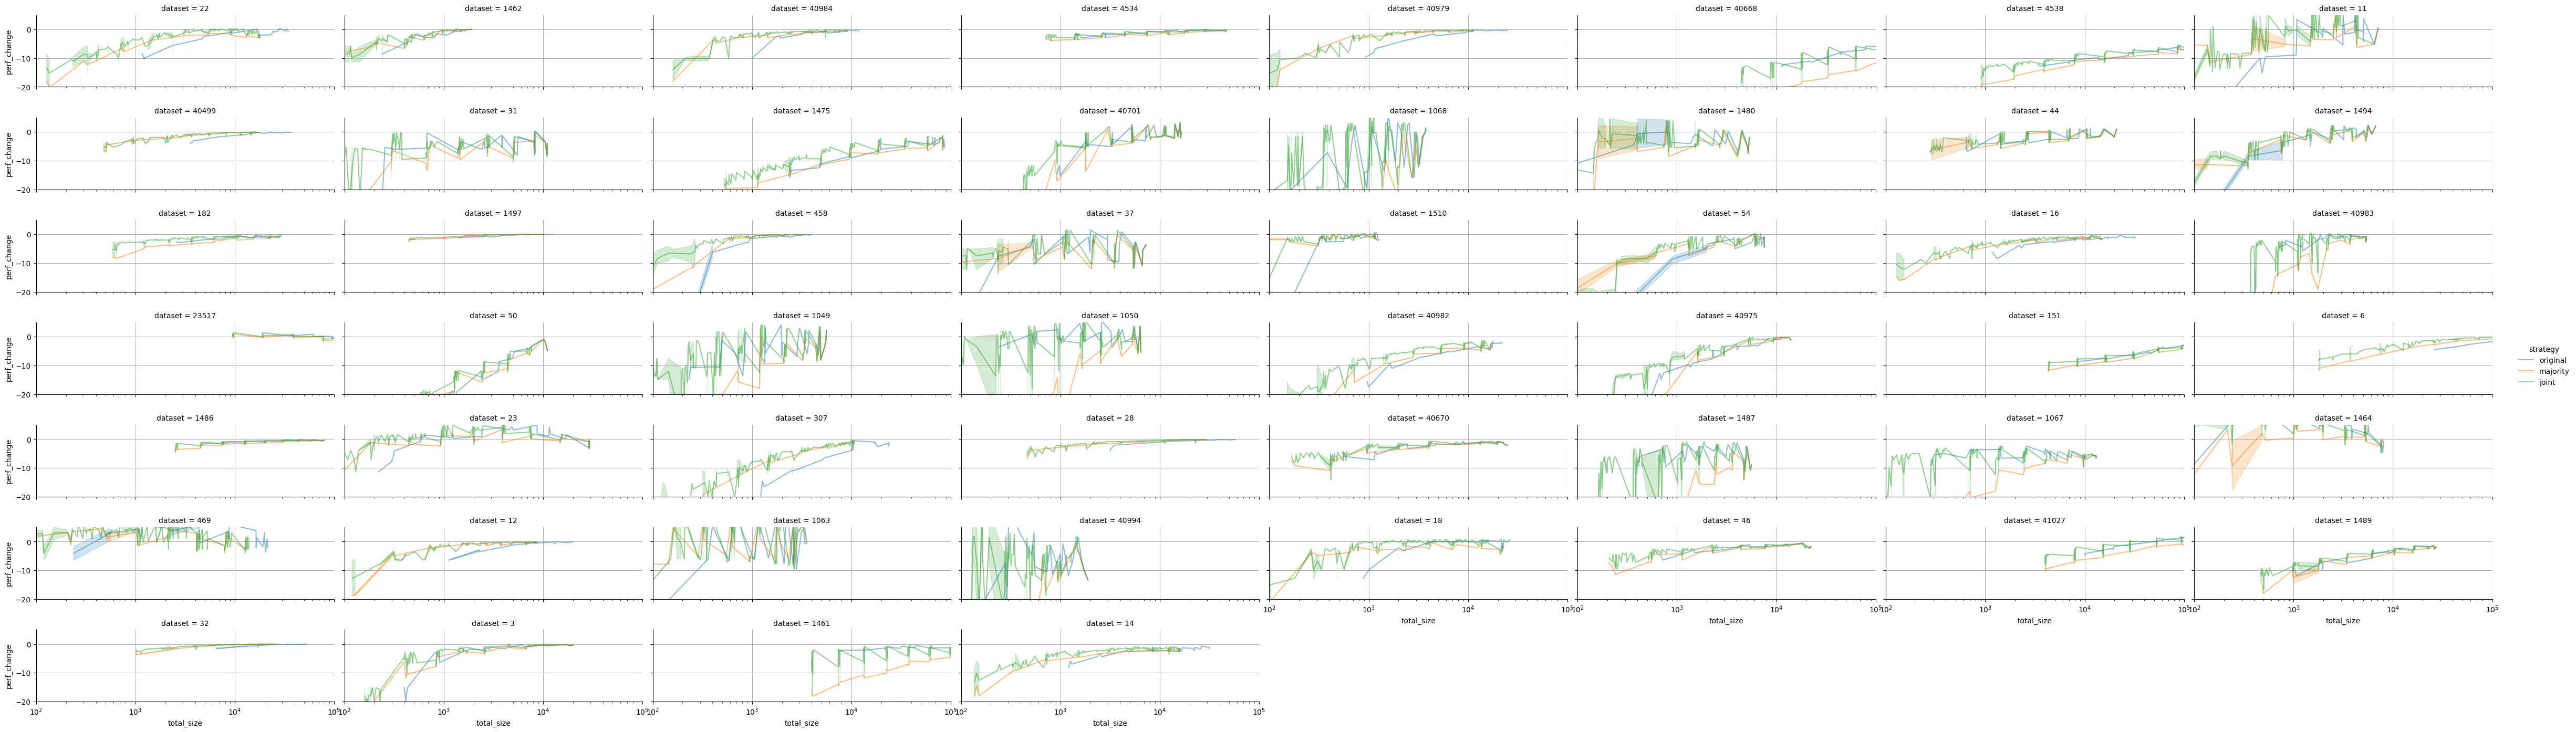

In [318]:
g = seaborn.relplot(data=reduced.reset_index(),
                    kind='line',
                    x='total_size',
                    y='perf_change',
                    hue='strategy',
                    col='dataset',
                    col_wrap=8,
                    aspect=3, height=2,
                    legend=True,
                    #errorbar=None,
                    #err_style='bars',
                    #lw=2.0,
                    #s=10.0,
                    alpha=0.5,
                   )
g.set(xscale="log")
g.set(ylim=(-20, 5))
g.set(xlim=(100, 100e3))
for ax in g.axes.flatten():
    ax.grid()  

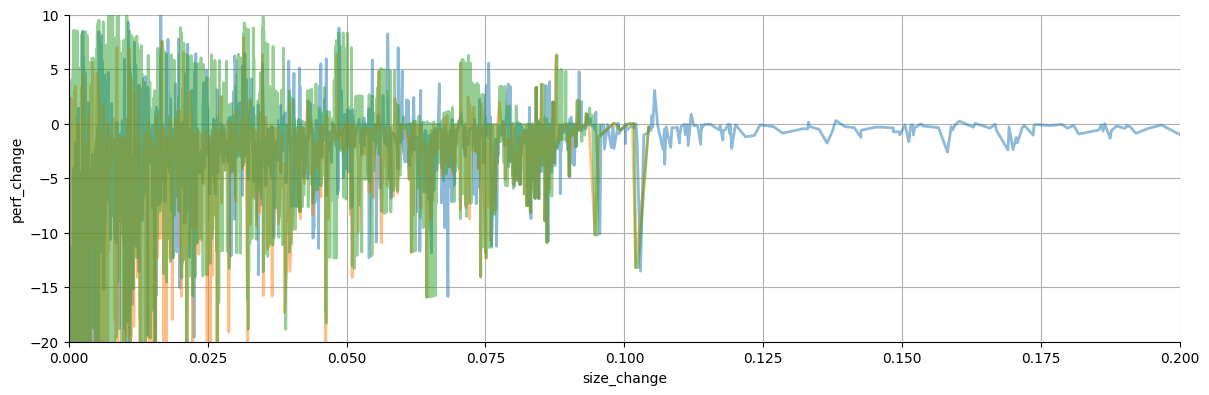

In [319]:
g = seaborn.relplot(data=reduced.reset_index(),
                    kind='line',
                    x='size_change',
                    y='perf_change',
                    hue='strategy',
                    #col='strategy',
                    #col_wrap=8,
                    aspect=3, height=4,
                    legend=False,
                    errorbar=None,
                    #err_style='bars',
                    lw=2.0,
                    alpha=0.5,
                   )
#g.set(xscale="log")
g.set(ylim=(-20, 10))
g.set(xlim=(0.0, 0.20))
for ax in g.axes.flatten():
    ax.grid()  

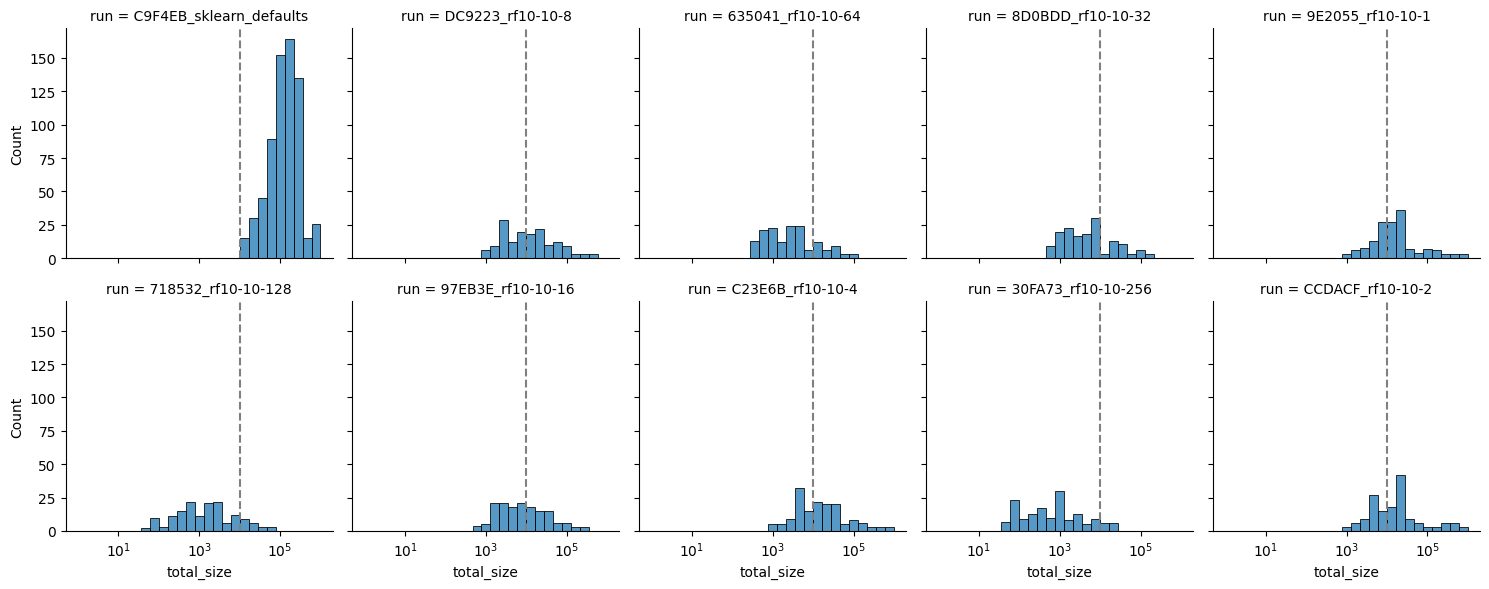

In [113]:
g = seaborn.displot(data=unoptimized.reset_index(), x='total_size', binrange=(0, 6), log_scale=True, col='run', col_wrap=5, height=3)
g.refline(x=10e3)


In [115]:
ref = 'C9F4EB_sklearn_defaults'
diff = scores - scores.loc[ref]
diff = diff.reset_index()
diff = diff[~diff.run.isin([ref])]
diff = diff.set_index(['run', 'dataset'])
diff

test_roc_auc  min_samples_leaf
run                dataset                                
30FA73_rf10-10-256 1049       -13.158400             255.0
                   1050        -6.697429             255.0
                   1063       -32.667032             255.0
                   1067        -6.881793             255.0
                   1068       -34.617718             255.0
...                                  ...               ...
DC9223_rf10-10-8   46          -1.419510               7.0
                   469          3.218500               7.0
                   50         -11.467521               7.0
                   54          -0.863423               7.0
                   6           -0.533963               7.0

[468 rows x 2 columns]

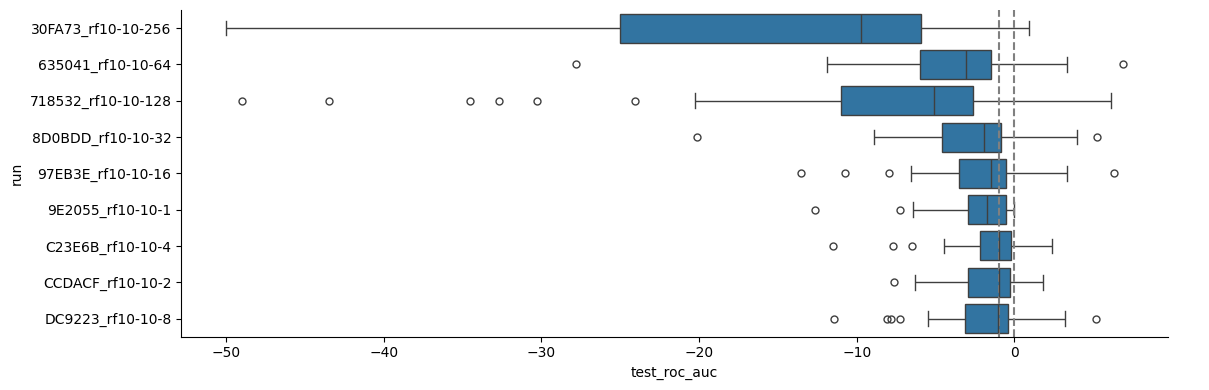

In [121]:
g = seaborn.catplot(data=diff.reset_index(), kind='box', x='test_roc_auc', y='run', height=4, aspect=3)
g.refline(x=0.0)
g.refline(x=-1.0)

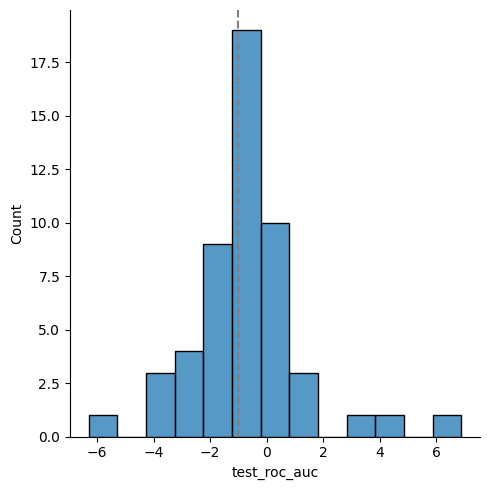

In [135]:
best = diff.groupby('dataset')[['test_roc_auc']].max()
g = seaborn.displot(data=best, kind='hist', x='test_roc_auc', binwidth=1.0)
g.refline(x=-1.0)

In [130]:
ranks = diff.groupby('dataset')[['test_roc_auc']].rank(ascending=False)
ranks

test_roc_auc
run                dataset              
30FA73_rf10-10-256 1049              9.0
                   1050              8.0
                   1063              8.5
                   1067              9.0
                   1068              9.0
...                                  ...
DC9223_rf10-10-8   46                3.0
                   469               4.0
                   50                4.0
                   54                2.0
                   6                 3.0

[468 rows x 1 columns]

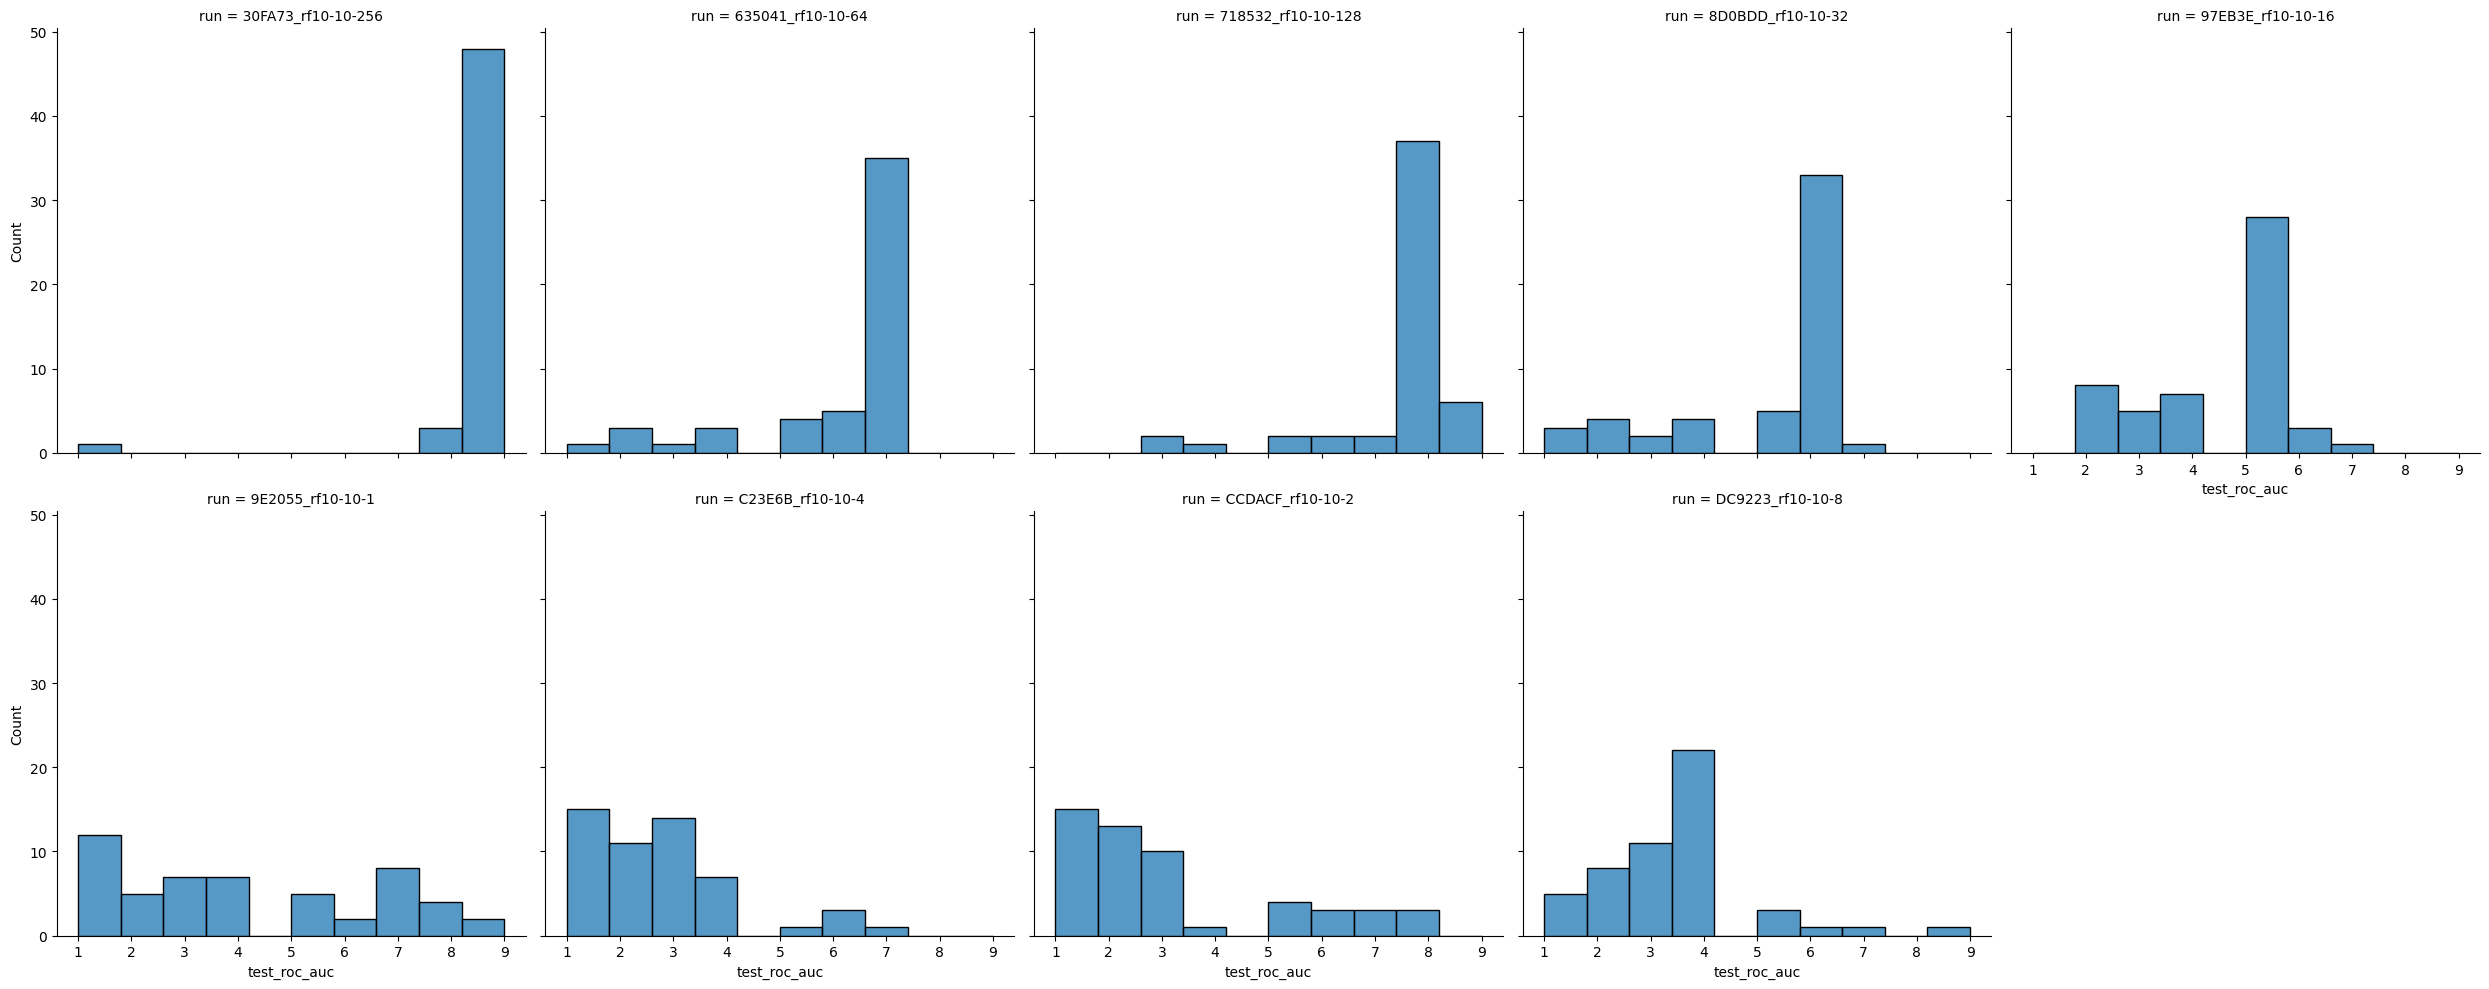

In [132]:
seaborn.displot(data=ranks.reset_index(), kind='hist', x='test_roc_auc', col='run', col_wrap=5)